In [4]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
train = pd.read_csv('./data/train.csv', index_col = 0)
test = pd.read_csv('./data/test.csv', index_col = 0)
submission = pd.read_csv('./data/sample_submission.csv', index_col = 0)
validation = pd.read_csv('./data/validation_sample.csv', index_col = 0)

/Users/yunsoowoo/miniforge3/envs/prj_final/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# 앞뒤 공백 삭제, 소문자처리, 줄바꿈 제거

In [63]:
train.full_log = train.full_log.apply(lambda x : x.strip())
train.full_log = train.full_log.apply(lambda x : x.lower())
train.full_log = train.full_log.str.replace('\n',' ', regex=True) 
train.full_log = train.full_log.str.replace('\\n',' ', regex=True) 


test.full_log = test.full_log.apply(lambda x : x.strip())
test.full_log = test.full_log.apply(lambda x : x.lower())
test.full_log = test.full_log.str.replace('\n',' ', regex=True) 
test.full_log = test.full_log.str.replace('\\n',' ', regex=True) 

# 특수문자

In [64]:
# 파일 경로 나타내는 슬래시, 시간 나타내는 콜론, 아이피 주소 나타내는 점, 날짜 나타내는 바 제외하고 모두 삭제

train.full_log = train.full_log.str.replace('[^a-zA-Zㄱ-ㅣ가-힣0-9:\*\-\./\\\\]+',' ', regex=True)
train.full_log = train.full_log.str.replace('[/\\\\]+','/', regex=True) # 역/슬래시 여러개는 슬래시 하나로 처리
train.full_log = train.full_log.str.replace(' ?(?P<note>[\/]) ?', ' \g<note> ', regex=True) # 앞뒤에 공백 추기

test.full_log = test.full_log.str.replace('[^a-zA-Zㄱ-ㅣ가-힣0-9:\*\-\./\\\\]+',' ', regex=True)
test.full_log = test.full_log.str.replace('[/\\\\]+','/', regex=True) 
test.full_log = test.full_log.str.replace(' ?(?P<note>[\/]) ?', ' \g<note> ', regex=True) 

# 의미 있는 숫자 마스킹

In [65]:
# IP, TIME, DATE
# 바뀐 점 : 용빈님 time mask 적용, 꺽쇠 대신 공백, ip에 와일드마스크(*) 추가

train.full_log = train.full_log.str.replace('[0-9\*]{1,3}\.[0-9\*]{1,3}\.[0-9\*]{1,3}\.[0-9\*]{1,3}', ' IP ', regex=True)
train.full_log = train.full_log.str.replace('(\d{1,2}\:\d{1,2}\:\d{1,2})|(\D\d{1,2}\:\d{1,2}\:\d{1,2})|(\d{1,2}\:\d{1,2})', ' TIME ', regex=True)
train.full_log = train.full_log.str.replace('((jan|feb|mar|apr|may|jun|jul|aug|dec|oct|sep|nov|mar) +[0-9]{1,2})|((19|20)[0-9]{2}-(0|1)[0-9]{1}-[0-3][0-9]{1})', 'DATE', regex=True)


test.full_log = test.full_log.str.replace('[0-9\*]{1,3}\.[0-9\*]{1,3}\.[0-9\*]{1,3}\.[0-9\*]{1,3}', ' IP ', regex=True)
test.full_log = test.full_log.str.replace('(\d{1,2}\:\d{1,2}\:\d{1,2})|(\D\d{1,2}\:\d{1,2}\:\d{1,2})|(\d{1,2}\:\d{1,2})', ' TIME ', regex=True)
test.full_log = test.full_log.str.replace('((jan|feb|mar|apr|may|jun|jul|aug|dec|oct|sep|nov|mar) +[0-9]{1,2})|((19|20)[0-9]{2}-(0|1)[0-9]{1}-[0-3][0-9]{1})', ' DATE ', regex=True)


# 남은 특수 문자 마저 삭제

In [66]:
train.full_log = train.full_log.str.replace('[:\.\-\*]+',' ', regex=True) 
test.full_log = test.full_log.str.replace('[:\.\-\*]+',' ', regex=True) 

# 위험도 2, 4, 6 유의

In [67]:
# 위험도 4, 6에 나오는 주요 단어
train.full_log = train.full_log.str.replace('sv260', 'sv_', regex=True)
train.full_log = train.full_log.str.replace('virbr0', 'virbr_', regex=True)
train.full_log = train.full_log.str.replace('enp2s0', 'enp_s_', regex=True)


test.full_log = test.full_log.str.replace('sv260', 'sv_', regex=True)
test.full_log = test.full_log.str.replace('virbr0', 'virbr_', regex=True)
test.full_log = test.full_log.str.replace('enp2s0', 'enp_s_', regex=True)

### 숫자 처리 전 저장

In [68]:
train.to_csv('train_no_special.csv')
test.to_csv('test_no_special.csv')

In [112]:
train = pd.read_csv('./data/train_no_special.csv', index_col=0)
test = pd.read_csv('./data/test_no_special.csv', index_col=0)

# 숫자 + 영어 혼합

In [113]:
train.full_log = train.full_log.str.replace('(?<=\d)[a-z]+(?=\d)', '', regex=True)
train.full_log = train.full_log.str.replace('\d+', 'NUM', regex=True)
train.full_log = train.full_log.str.replace('(?<=[a-z])NUM', ' NUM', regex=True)
train.full_log = train.full_log.str.replace('NUM(?=[a-z])', 'NUM ', regex=True)



test.full_log = test.full_log.str.replace('(?<=\d)[a-z]+(?=\d)', '', regex=True)
test.full_log = test.full_log.str.replace('\d+', 'NUM', regex=True)
test.full_log = test.full_log.str.replace('(?<=[a-z])NUM', ' NUM', regex=True)
test.full_log = test.full_log.str.replace('NUM(?=[a-z])', 'NUM ', regex=True)


# 숫자 여러개 하나로, 공백 한 칸으로

In [114]:
train.full_log = train.full_log.str.replace('NUM (NUM ?)+', ' NUM ', regex=True)
train.full_log = train.full_log.str.replace(' +', ' ', regex=True)

test.full_log = test.full_log.str.replace('NUM (NUM ?)+', ' NUM ', regex=True)
test.full_log = test.full_log.str.replace(' +', ' ', regex=True)

### 특수문자, 숫자영문 혼합 없음 저장

In [115]:
train.to_csv('train_no_special_no_mix.csv')
test.to_csv('test_no_special_no_mix.csv')

In [116]:
train.full_log.loc[1]

'DATE TIME localhost logstash DATE TIME NUM info logstash outputs elasticsearch retrying failed action with response code NUM type unavailable shards exception reason wazuh alerts audit NUM x NUM primary shard is not active timeout NUM m request bulkshardrequest wazuh alerts audit NUM x NUM containing NUM requests '

# 띄어쓰기 토크나이징 및 인코딩

In [6]:
train = pd.read_csv('./data/train_no_special_no_mix.csv', index_col=0)
test = pd.read_csv('./data/test_no_special_no_mix.csv', index_col=0)

In [7]:
# 텍스트 데이터

text = []
for i in range(train.shape[0]):
    text.append(train.full_log.loc[i])


In [8]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(text, target_vocab_size=2**13)

In [9]:
print(tokenizer.subwords[:20])
print(tokenizer.vocab_size)

['NUM_', ' / ', 'TIME_', 'error_', 'type_', 'audit_', 'DATE_', 'a_', 'msg_', 'localhost_', 'no_', 'living_', 'cap_', 'n_', 'js_', 'at_', 'r_', 'usr', 'message_', 's_']
8347


In [10]:
# 인코딩
tokens = [tokenizer.encode(sentence) for sentence in text]

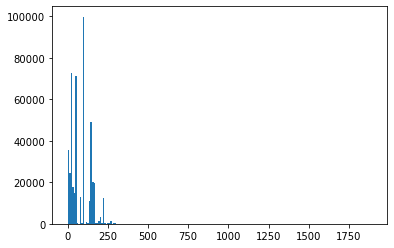

In [8]:
lengths = [len(j) for j in tokens]
plt.hist(lengths, bins=200)
plt.show()

In [9]:
max(lengths)

1893

In [11]:
tokens = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen=400, padding='post', truncating='post')

In [12]:
label = np.array(train.level)

# 모델 학습

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(tokens, label, test_size=0.3, random_state=42)

In [10]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(331080, 400)
(331080,)
(141892, 400)
(141892,)


In [11]:
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

mc = ModelCheckpoint('model02_subword.h5', monitor='val_acc', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_acc', mode='max',patience=5)

# vocab_size = tokenizer.vocab_size + 1

model = Sequential()
model.add(Embedding(tokenizer.vocab_size, 200)) # 임베딩 벡터의 차원
model.add(Dropout(0.5))
model.add(LSTM(32)) # RNN 셀의 hidden_size는 32
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, Y_train, epochs=20, batch_size=128, validation_split=0.2, callbacks=[es, mc])

Epoch 1/20
2070/2070 [==============================] - 207s 100ms/step - loss: 0.7136 - acc: 0.7043 - val_loss: 0.6787 - val_acc: 0.7031
Epoch 2/20
2070/2070 [==============================] - 206s 100ms/step - loss: 0.6756 - acc: 0.7057 - val_loss: 0.7504 - val_acc: 0.7116
Epoch 3/20
2070/2070 [==============================] - 202s 98ms/step - loss: 0.1146 - acc: 0.9715 - val_loss: 2.7773 - val_acc: 0.6923
Epoch 4/20
2070/2070 [==============================] - 210s 101ms/step - loss: 0.0959 - acc: 0.9844 - val_loss: 2.7160 - val_acc: 0.6991
Epoch 5/20
2070/2070 [==============================] - 214s 103ms/step - loss: 0.0883 - acc: 0.9846 - val_loss: 3.6225 - val_acc: 0.7174
Epoch 6/20
2070/2070 [==============================] - 209s 101ms/step - loss: 0.0435 - acc: 0.9884 - val_loss: 3.4826 - val_acc: 0.7093
Epoch 7/20
2070/2070 [==============================] - 209s 101ms/step - loss: 0.0404 - acc: 0.9873 - val_loss: 3.4324 - val_acc: 0.7172
Epoch 8/20
2070/2070 [=============

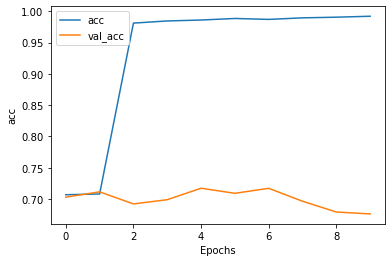

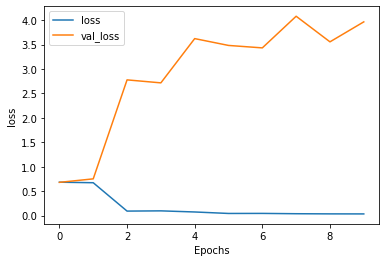

In [12]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+ metric])
    plt.show()

for j in ['acc', 'loss']:
    plot_graphs(history, j)


In [13]:
model.evaluate(X_test, Y_test, batch_size=64)

2218/2218 [==============================] - 39s 18ms/step - loss: 2.7733 - acc: 0.7780


[2.773263692855835, 0.7780424356460571]

In [3]:
from tensorflow.keras.models import load_model
model = load_model("model02_subword.h5")

In [15]:
pred = model.predict(X_test)

In [16]:
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [17]:
prediction = np.reshape(prediction, (141892,))

In [18]:
Y_test.shape

(141892,)

In [19]:
crosstab = pd.crosstab(Y_test, prediction, rownames=['real'], colnames=['pred'])
crosstab

pred,0,1,3,5
real,,,,
0,100094,4,85,0
1,171,39567,45,0
2,5,1,0,0
3,60,28,1140,0
4,0,0,3,0
5,70,42,513,61
6,2,1,0,0


# test 셋

In [20]:
test_text = []
for i in range(test.shape[0]):
    test_text.append(test.full_log.iloc[i])

In [21]:
test_encoded = [tokenizer.encode(sentence) for sentence in test_text]
test_tokens = tf.keras.preprocessing.sequence.pad_sequences(test_encoded, maxlen=400, padding='post', truncating='post')

In [22]:
results = model.predict(test_tokens)

In [23]:
test_prediction = []
for i in results:
    test_prediction.append(np.argmax(i))

In [24]:
test_test_prediction = np.reshape(test_prediction, (test.shape[0],))

In [25]:
test_test_prediction[np.where(np.max(results, axis=1) < 0.9)] = 7

In [26]:
submission['level']=test_test_prediction
submission.value_counts()

level
0        999384
1        395853
7         23679
dtype: int64

In [27]:
# submission.to_csv('submission_model02_subword.csv')